In [ ]:
#-------------------------------------------------------------------------------------------------------
#The code I used was taken from https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

#Name: Tyler Gilbert
#Class: CSCI 424
#Date: 12/7/2021
#Desc.: CNN using transfer learning from VGG16 to classify cloud images
#--------------------------------------------------------------------------------------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.models import Model
from pathlib import Path
import tensorflow as tf
import numpy as np
import cv2
import os

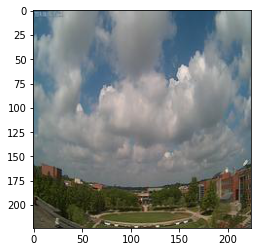

In [ ]:
#a cumulus cloud from the training set
img = image.load_img("/content/drive/MyDrive/CloudImages/train/cumulus/1565880960.jpg")
plt.imshow(img)

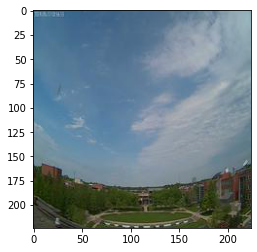

In [ ]:
img2 = image.load_img("/content/drive/MyDrive/CloudImages/train/cirrus/1558104960.jpg")
plt.imshow(img2)

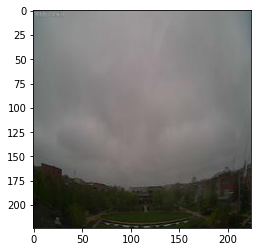

In [ ]:
img3 = image.load_img("/content/drive/MyDrive/CloudImages/train/stratus/1557672960.jpg")
plt.imshow(img3)

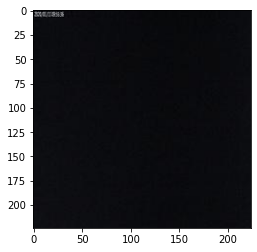

In [ ]:
img4 = image.load_img("/content/drive/MyDrive/CloudImages/train/other/1578754560.jpg")
plt.imshow(img4)

In [ ]:
BATCH_SIZE = 32
#The images need to be preprocessed the same way VGG16 preprocessed their images

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

In [ ]:
traingen = train_generator.flow_from_directory("/content/drive/MyDrive/CloudImages/train",
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=86)

validgen = train_generator.flow_from_directory("/content/drive/MyDrive/CloudImages/train",
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=86)

testgen = test_generator.flow_from_directory("/content/drive/MyDrive/CloudImages/test",
                                             target_size=(224, 224),
                                             class_mode=None,                                            
                                             batch_size=1,
                                             shuffle=False,
                                             seed=86)

Found 387 images belonging to 4 classes.
Found 66 images belonging to 4 classes.
Found 133 images belonging to 4 classes.


In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=4

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)
print(vgg_model.summary())

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# !pip uninstall livelossplot

!pip install livelossplot==0.5.2

from livelossplot import PlotLossesKeras
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

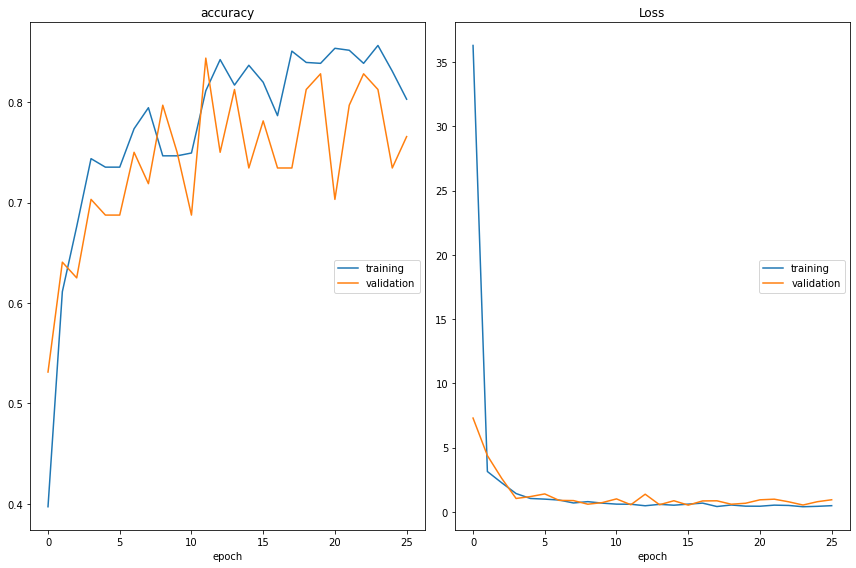

accuracy
	training         	 (min:    0.397, max:    0.856, cur:    0.803)
	validation       	 (min:    0.531, max:    0.844, cur:    0.766)
Loss
	training         	 (min:    0.403, max:   36.295, cur:    0.486)
	validation       	 (min:    0.528, max:    7.303, cur:    0.945)
12/12 [==============================] - 9s 772ms/step - loss: 0.4857 - accuracy: 0.8028 - val_loss: 0.9449 - val_accuracy: 0.7656
CPU times: user 4min 33s, sys: 26.2 s, total: 4min 59s
Wall time: 9min 40s


In [ ]:
%%time 

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [ ]:
# Generate predictions
vgg_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 78.95%


In [ ]:
traingen.reset()
validgen.reset()
testgen.reset()

# tl_checkpoint_2 = ModelCheckpoint(filepath='tl_model_v2.weights.best.hdf5',
#                                   save_best_only=True,
#                                   verbose=1)

# Use a smaller learning rate
optim_2 = Adam(learning_rate = 0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)
print(vgg_model_ft.summary())

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

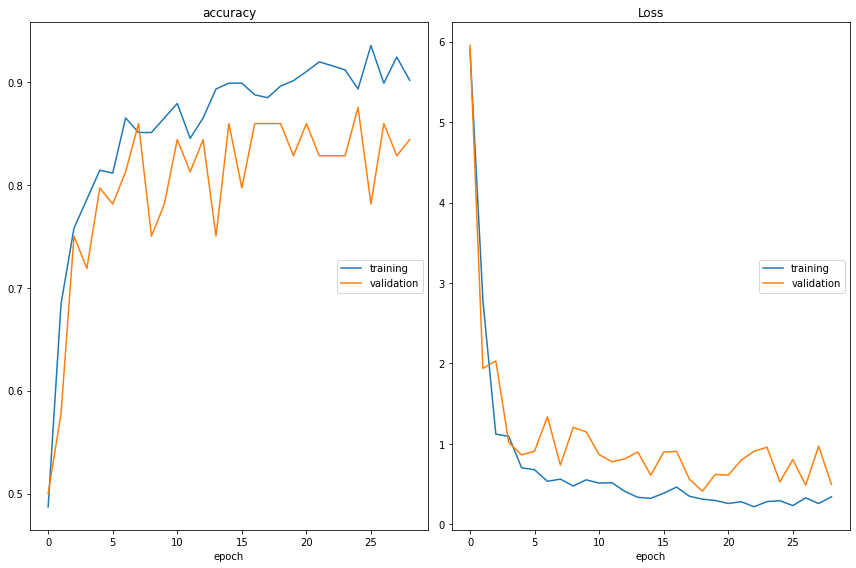

accuracy
	training         	 (min:    0.487, max:    0.935, cur:    0.901)
	validation       	 (min:    0.500, max:    0.875, cur:    0.844)
Loss
	training         	 (min:    0.219, max:    5.901, cur:    0.343)
	validation       	 (min:    0.413, max:    5.952, cur:    0.494)
12/12 [==============================] - 10s 854ms/step - loss: 0.3432 - accuracy: 0.9014 - val_loss: 0.4944 - val_accuracy: 0.8438
CPU times: user 5min 16s, sys: 27.1 s, total: 5min 43s
Wall time: 8min 11s


In [ ]:
%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_2, early_stop, plot_loss_2],
                                  verbose=1)

In [ ]:
# Generate predictions
vgg_model_ft.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

vgg_preds_ft = vgg_model_ft.predict(testgen)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

In [ ]:
vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))

VGG16 Model Accuracy with Fine-Tuning: 87.22%
